In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
#from matplotlib import gridspec
import time
#####################################################################

** Calculation of C matrix, and diffraction efficiencies**
--------------------------------------------------------------------------- 

>Assuming n is the number of harmonics and is an odd number

>Boundary conditions at the input boundary (z=0):
$$
\delta_{i0}+R_i=
\sum_{m=1}^{n} w_{i,m}\left[c^+_m + c^-_m\exp(-k_0 q_m d)\right] ~~~~~ (19)
$$
$$
\jmath \left[n_I \cos(\theta)\delta_{i0} + \frac{k_{I,zi}}{k_0}R_i\right]=
\sum_{m=1}^{n} v_{i,m}\left[c^+_m - c^-_m \exp(-k_0 q_m d)\right] ~~~~~ (20)
$$

>Boundary conditions at the output boundary (z=d):
$$
\sum_{m=1}^{n} w_{i,m}\left[c^+_m \exp(-k_0 q_m d)+c^-_m\right] = T_i ~~~~~ (22)
$$
$$
\sum_{m=1}^{n} v_{i,m}\left[c^+_m \exp(-k_0 q_m d)-c^-_m\right] =
\jmath\frac{k_{II,zi}}{k_0}T_i ~~~~~ (23)
$$


>from eqs. (19), (20)
$$ 
\sum_{m=1}^{n} v_{i,m}\left[c^+_m - c^-_m \exp(-k_0 q_m d)\right] =
\left[\jmath \left(n_I \cos(\theta) + \frac{k_{I,zi}}{k_0}\right)\delta_{i0}\right]_{n\times1}
-\jmath\frac{k_{I,zi}}{k_0}
\left[
\sum_{p=1}^{n} w_{i,p}\left[c^+_p + c^-_p\exp(-k_0 q_p d)\right] 
\right] 
$$ 

>from eqs. (22), (23)
$$
\sum_{m=1}^{n} v_{i,m}\left[c^+_m \exp(-k_0 q_m d)-c^-_m\right] = \left[0\right]_{n\times1} + \jmath\frac{k_{II,zi}}{k_0}\sum_{p=1}^{n} w_{i,p}\left[c^+_p \exp(-k_0 q_p d)+c^-_p\right]
$$

>Assuming $V$, $W$, $X$, $Y_I$, and $Y_{II}$ are matrices with diagonal elements $v_{i,m}$, $w_{i,m}$, $\exp(-k_0 q_m d)$, $\frac{k_{I,zi}}{k_0}$, and $\frac{k_{II,zi}}{k_0}$:



$$
\begin{bmatrix} 
    V       & -VX \\
    VX       & -V     
\end{bmatrix}
\begin{bmatrix}
    c^+ \\
    c^-
\end{bmatrix}
= 
\begin{bmatrix}
    \left[\jmath \left(n_I \cos(\theta) + \frac{k_{I,zi}}{k_0} \right)\delta_{i0}\right]_{n\times1} \\
    \left[0\right]_{n\times1}
\end{bmatrix}
+
\begin{bmatrix}
    -\jmath Y_{I}W       & -\jmath Y_{I}WX \\
    \jmath Y_{II}WX       & \jmath Y_{II}W
\end{bmatrix}
\begin{bmatrix}
    c^+ \\
    c^-
\end{bmatrix}
$$
>or

$$
\begin{bmatrix} 
    V+\jmath Y_{I}W       & (-V+\jmath Y_{I}W)X \\
    (V-\jmath Y_{II}W)X        & -V-\jmath Y_{II}W     
\end{bmatrix}
\begin{bmatrix}
    c^+ \\
    c^-
\end{bmatrix}
= 
\begin{bmatrix}
    \left[\jmath \left(n_I \cos(\theta) + \frac{k_{I,zi}}{k_0}\delta_{i0} \right)\right]_{n\times1} \\
    \left[0\right]_{n\times1}
\end{bmatrix}
$$

>C matrix elements can be calculated from


$$
\begin{bmatrix}
    c^+ \\
    c^-
\end{bmatrix}
= 
\begin{bmatrix} 
    V+\jmath Y_{I}W       & (-V+\jmath Y_{I}W)X \\
    (V-\jmath Y_{II}W)X        & -V-\jmath Y_{II}W     
\end{bmatrix}^{-1}
\begin{bmatrix}
    \left[\jmath \left(n_I \cos(\theta) + \frac{k_{I,zi}}{k_0}\delta_{i0} \right)\right]_{n\times1} \\
    \left[0\right]_{n\times1}
\end{bmatrix}
$$


In [2]:
# =========================  Calculating diffraction efficiencies ==============================
def dTE(nI, epsGR, epsRD, nII, Lambda, fillRD, d, lambda_, theta, N):

    n = np.arange((1-N), N)
    n0 = (N + 1) / 2 # middle of array n
    m = np.arange(-(N-1)/2, (N-1) / 2 + 1)
    m0 = (N - 1) / 2

    # Fourier harmonics of epsilon in grating region, eq. 2
    epsilon = np.zeros(len(n)) - 0.j #---------------------
    epsilon[0:N-1] = (epsRD - epsGR) * np.sin(np.pi * fillRD * n[0:N-1]) / (np.pi * n[0:N-1])
    epsilon[N-1] = epsRD * fillRD + epsGR * (1. - fillRD)
    epsilon[N:len(n)] = (epsRD - epsGR) * np.sin(np.pi * fillRD * n[N:len(n)]) / (np.pi * n[N:len(n)])    

    
    # Free space k-vector
    k0 = 2 * np.pi / lambda_
    # Parallel component of the k-vector for ith diffraction order
    # for all media, eq. 6
    kxi = k0 * (nI * np.sin(theta) - m * (lambda_ / Lambda)) + 0.j
    # Normal components of the k-vector for ith diffraction order
    # in the ambient and the substrate, eq.7
    Z = (nI * k0)**2 - kxi**2
    kIzi = np.sign(Z) * np.sqrt(Z)
    Z = (nII * k0)**2 - kxi**2
    kIIzi = np.sign(Z) * np.sqrt(Z)


    # Set up the A matrix: Eq. 16
    Kx = np.diag(kxi / k0, 0)

    E = np.zeros((N,N)) + 0.j
#    for j in range(N):
#        E[j,N-1::-1] = epsilon[j:j+N]

    for j in range(N):
        E[j,:] = epsilon[j:j+N]
    E = np.fliplr(E)
    A = np.dot(Kx, Kx) - E

    # Find eigenvalues and eigenvectors of A matrix
    Q, W = LA.eig(A) 
    q = np.sqrt(Q)
    Q = np.diag(q,0)

    # Set up matrix V
    V = np.dot(W, Q)

    # Eliminate Ti from eq. 22 and 23 to calculate components of C matrix
    YI = np.diag(kIzi / k0, 0)
    YII = np.diag(kIIzi / k0, 0)
    X = np.diag(np.exp(-k0 * q * d), 0)

    # to avoid repeated operation some new variables are introduced
    VX = np.dot(V, X) 
    jYIW = 1j * np.dot(YI, W) 
    jYIIW = 1j * np.dot(YII, W) 
    M11 = jYIW + V
    M12 = np.dot(jYIW , X)- VX
    M21 = VX - np.dot(jYIIW, X)
    M22 = -V - jYIIW
    
#    M11 = 1j * np.dot(YI, W) + V
#    M12 = np.dot(1j * np.dot(YI, W)- V, X)
#    M21 = np.dot(V - 1j * np.dot(YII, W), X)
#    M22 = -V - 1j * np.dot(YII, W)

    L = np.vstack(( np.hstack((M11, M12)), np.hstack((M21, M22)) ))

    R = np.zeros((2*N, 1)) + 0.j
    R[m0, 0] = 1j * (kIzi[m0] / k0 + nI * np.cos(theta))
    
    # Solve for C components
    C = np.dot(LA.inv(L), R)
    
    # Find Ri: Eq. 21
    LR1 = np.vstack((np.eye(N), -1j * YI))
    
    M = np.vstack(( np.hstack((W, np.dot(W, X))), np.hstack((V, np.dot(-V, X))) ))
    M = np.dot(M, C)
    Z = np.zeros((2*N, 1)) + 0.j
    Z[m0, 0] = 1.
    Z[3*m0+1, 0] = 1j * np.cos(theta) * nI
    RR1 = M - Z

    # due to non-square matrix psuedo inverse is used
    RI = np.dot(LA.pinv(LR1), RR1)
    DEri = np.real(np.transpose(RI * np.conj(RI)) * np.real(kIzi / (k0 * nI * np.cos(theta))))
    # Find Ti: Eq. 24
    LT1 = np.vstack((np.eye(N), 1j * YII))
    RT1 = np.dot(np.vstack(( np.hstack(( np.dot(W, X), W)), np.hstack(( np.dot(V, X), -V)) )), C)
    TI = np.dot(LA.pinv(LT1), RT1)
    DEti = np.real(np.transpose(TI * np.conj(TI)) * np.real(kIIzi / (k0 * nI * np.cos(theta))))  

    return DEri, DEti


###################################################################################################

4  0.683745861053


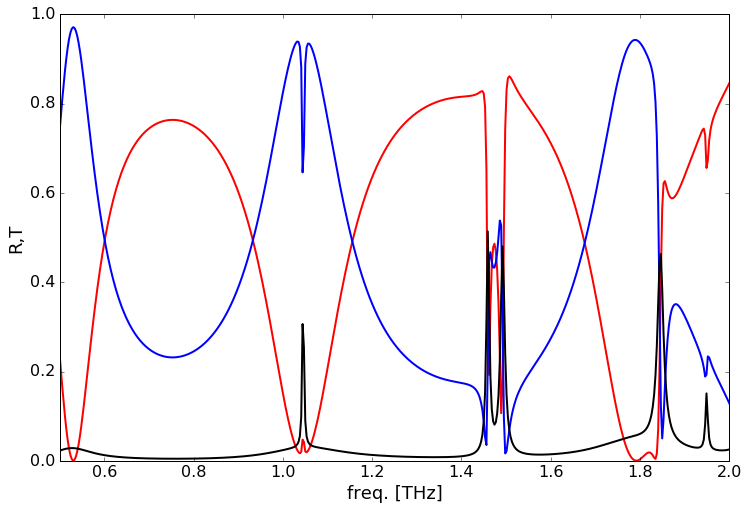

In [19]:
nI = 1.0
epsGR = -1500
epsRD = (3.6-0.005j)**2
nII = 1.0
Lambda = 100e-6
fillRD = 0.90
d= 50e-6
theta = 15
N = 21
NN = (N - 1) / 2
f1 = 0.5e12
f2 = 2.0e12
freq = f1
lambda_ = 3e8 / freq
imax = 500

# Set order array
if N%2 == 0:
    N = N + 1
    print 'Order replaced by odd number, N =',N

# Convert angle to radians
theta = theta * np.pi / 180.


Ref = np.zeros((imax, N+1))
Tra = np.zeros((imax, N+1))
t = time.time()
for ii in range(imax):
    
    R, T = dTE(nI, epsGR, epsRD, nII, Lambda, fillRD, d, lambda_, theta, N);

    Ref[ii,0] = 3e8 / lambda_ / 1e12;
    Ref[ii,1:N+1] = R
    Tra[ii,0] = 3e8 / lambda_ / 1e12
    Tra[ii,1:N+1] = T

    freq = freq + (f2 - f1) / (imax - 1)
    lambda_ = 3e8 / freq
print "4 ", time.time()-t

fig = plt.figure(figsize=(12, 8))
fig.add_subplot()
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(Ref[:,0], Ref[:,(N+1)/2],'r', linewidth=2)
plt.plot(Tra[:,0], Tra[:,(N+1)/2],'b', linewidth=2)
plt.plot(Tra[:,0], 1 - Tra[:,(N+1)/2] -Ref[:,(N+1)/2],'k', linewidth=2)
plt.xlim([f1/1e12, f2/1e12])
plt.ylim([0, 1])

plt.ylabel('R,T', fontsize=18)
plt.xlabel('freq. [THz]', fontsize=18)


** Calculation of the fields **
--------------------------------------------------------------------------- 

>** Inside grating **

>tangential electric and magnetic fields in the grating region

$$
S_{yi}(z)=\sum_{m=1}^{n} w_{i,m}\{c^+_m\exp(-k_0 q_m z) + c^-_m\exp\left[k_0 q_m (z-d)\right]\} ~~~~~ (17)
$$
$$
U_{xi}(z)=\sum_{m=1}^{n} v_{i,m}\{-c^+_m\exp(-k_0 q_m z) + c^-_m\exp\left[k_0 q_m (z-d)\right]\} ~~~~~ (18)
$$

>Assume $W$, $V$, $X^+$, and $X^-$ are matrices with elements $w_{i,m}$, $v_{i,m}$, $\exp(-k_0 q_m z)$, and $\exp[k_0 q_m (z-d)]$, then (17) and (18) can be written and solved in a matrix form:

$$
\begin{bmatrix} 
    S \\
    U     
\end{bmatrix}
=
\begin{bmatrix} 
    WX^+       & WX^- \\
    -VX^+       & VX^-     
\end{bmatrix}
\begin{bmatrix}
    c^+ \\
    c^-
\end{bmatrix}
$$

>then electric and magnetic fields inside the grating can be calculated using 
$$
E_{gy} = \sum_{i} S_{yi}(z) \exp(-\jmath k_{xi} x)
$$
$$
H_{gx} = -\jmath\left(\frac{\epsilon_0}{\mu_0}\right)\sum_{i} U_{xi}(z) \exp(-\jmath k_{xi} x)
$$


In [9]:
# =========================  Calculating diffraction efficiencies ==============================
def F_TE(nI, epsGR, epsRD, nII, Lambda, fillRD, d, lambda_, theta, N, z):

    n = np.arange((1-N), N)
    n0 = (N + 1) / 2 # middle of array n
    m = np.arange(-(N-1)/2, (N-1) / 2 + 1)
    m0 = (N - 1) / 2

    # Fourier harmonics of epsilon in grating region, eq. 2
    epsilon = np.zeros(len(n)) -0.j #---------------------
    epsilon[0:N-1] = (epsRD - epsGR) * np.sin(np.pi * fillRD * n[0:N-1]) / (np.pi * n[0:N-1])
    epsilon[N-1] = epsRD * fillRD + epsGR * (1. - fillRD)
    epsilon[N:len(n)] = (epsRD - epsGR) * np.sin(np.pi * fillRD * n[N:len(n)]) / (np.pi * n[N:len(n)])    
    
    # Free space k-vector
    k0 = 2 * np.pi / lambda_
    # Parallel component of the k-vector for ith diffraction order
    # for all media, eq. 6
    kxi = k0 * (nI * np.sin(theta) - m * (lambda_ / Lambda)) + 0.j
    # Normal components of the k-vector for ith diffraction order
    # in the ambient and the substrate, eq.7
    Z = (nI * k0)**2 - kxi**2
    kIzi = np.sign(Z) * np.sqrt(Z)
    Z = (nII * k0)**2 - kxi**2
    kIIzi = np.sign(Z) * np.sqrt(Z)


    # Set up the A matrix: Eq. 16
    Kx = np.diag(kxi / k0, 0)

    E = np.zeros((N,N)) + 0.j
    for j in range(N):
        E[j,N-1::-1] = epsilon[j:j+N]
    
    A = np.dot(Kx, Kx) - E

    # Find eigenvalues and eigenvectors of A matrix
    Q, W = LA.eig(A) 
    q = np.sqrt(Q)
    Q = np.diag(q,0)

    # Set up matrix V
    V = np.dot(W, Q)

    # Eliminate Ti from eq. 22 and 23 to calculate components of C matrix
    YI = np.diag(kIzi / k0, 0)
    YII = np.diag(kIIzi / k0, 0)
    X = np.diag(np.exp(-k0 * q * d), 0)

    # to avoid repeated operation some new variables are introduced
    VX = np.dot(V, X) 
    jYIW = 1j * np.dot(YI, W) 
    jYIIW = 1j * np.dot(YII, W) 
    M11 = jYIW + V
    M12 = np.dot(jYIW , X)- VX
    M21 = VX - np.dot(jYIIW, X)
    M22 = -V - jYIIW
    L = np.vstack(( np.hstack((M11, M12)), np.hstack((M21, M22)) ))

    R = np.zeros((2*N, 1)) + 0.j
    R[m0, 0] = 1j * (kIzi[m0] / k0 + nI * np.cos(theta))
    
    # Solve for C components
    C = np.dot(LA.pinv(L), R)
    
    # Find Ri: Eq. 21
    Xp = np.diag(np.exp(-k0 * q * z), 0)
    Xm = np.diag(np.exp(k0 * q * (z-d)), 0)
    M11 = np.dot(W , Xp)
    M12 = np.dot(W , Xm)
    M21 = np.dot(-V , Xp)
    M22 = np.dot(V , Xm)
    Fz = np.dot(np.vstack(( np.hstack((M11, M12)), np.hstack((M21, M22)) )), C)

    return kxi, Fz


###################################################################################################

4  0.593924999237


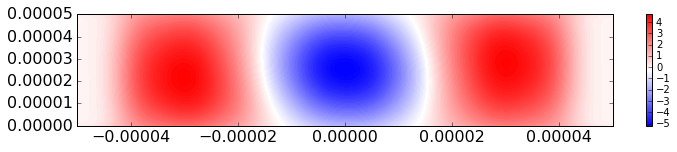

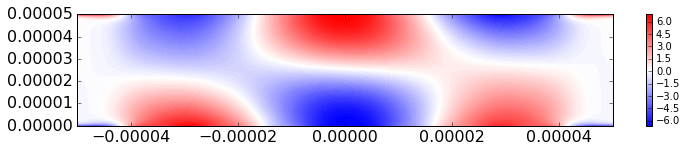

In [33]:
nI = 1.0
epsGR = -1500
epsRD = (3.6-0.005j)**2
nII = 1.0
Lambda = 100e-6
fillRD = 0.90
d= 50e-6
theta = 5
N = 21
NN = (N - 1) / 2
freq = 1.045e12
freq = 1.49e12
lambda_ = 3e8 / freq

# Set order array
if N%2 == 0:
    N = N + 1
    print 'Order replaced by odd number, N =',N

# Convert angle to radians
theta = theta * np.pi / 180.


Ref = np.zeros((imax, N+1))
Tra = np.zeros((imax, N+1))
t = time.time()

x = np.linspace(-Lambda/2, Lambda/2, 200)
z = np.linspace(0, d, 80)
Egy = np.zeros((len(z), len(x)))+0.j
Hgx = np.zeros((len(z), len(x)))+0.j

for jj in range(len(z)):
    kxi, Fz = F_TE(nI, epsGR, epsRD, nII, Lambda, fillRD, d, lambda_, theta, N, z[jj]);
    for ii in range(len(x)):
        Egy[jj, ii] = np.real(np.sum(np.transpose(Fz[0:N]) * np.exp(-1j * kxi * x[ii])))
        Hgx[jj, ii] = np.real(np.sum(np.transpose(Fz[N:2*N]) * np.exp(-1j * kxi * x[ii])))

print "4 ", time.time()-t

fig = plt.figure(figsize=(12, 2))
fig.add_subplot()
plt.tick_params(axis='both', which='major', labelsize=16)
#v = np.linspace(-4, 4, 15, endpoint=True)
plt.contourf(x, z, Egy, 100, cmap=plt.cm.bwr)
plt.colorbar()

fig = plt.figure(figsize=(12, 2))
fig.add_subplot()
plt.tick_params(axis='both', which='major', labelsize=16)
#v = np.linspace(-4, 4, 15, endpoint=True)
plt.contourf(x, z, Hgx, 100, cmap=plt.cm.bwr)
plt.colorbar()
